In [34]:
from __future__ import print_function

import time
import os
import h5py
import numpy as np
from tqdm.auto import trange

import torch

from util import adjust_learning_rate
from util import set_optimizer, save_model

from my_util import Params, option_preprocess
from my_util import modis_loader, set_model
from my_util import train_modis

In [2]:
model_path = "./experiments/base_modis_model/SimCLR_modis_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.07_trial_1_cosine_warm/" \
             "SimCLR_modis_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.07_trial_0_cosine_warm"
model_name = "last.pth"

In [3]:
opt_path = './experiments/base_modis_model/opts.json'
opt = Params(opt_path)
opt = option_preprocess(opt)

In [12]:
model, criterion = set_model(opt, cuda_use=False)

In [ ]:
model.summary()

In [10]:
device = torch.device('cpu')
model_dict = torch.load(os.path.join(model_path, model_name), map_location=device)/

In [11]:
model.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [ ]:
def train_modis(train_loader, model, cuda_use=False):
    """one epoch training"""
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    end = time.time()
    for idx, images in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = torch.cat([images[0], images[1]], dim=0)
        if torch.cuda.is_available() and cuda_use:
            images = images.cuda(non_blocking=True)
            #labels = labels.cuda(non_blocking=True)
        bsz = images.shape[0] // 2

        # warm-up learning rate
        warmup_learning_rate(opt, epoch, idx, len(train_loader), optimizer)

        # compute loss
        features = model(images)
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        if opt.method == 'SupCon':
            loss = criterion(features, labels)
        elif opt.method == 'SimCLR':
            loss = criterion(features)
        else:
            raise ValueError('contrastive method not supported: {}'.
                             format(opt.method))

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        # print info
        if (idx + 1) % opt.print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses))
            sys.stdout.flush()

    return losses.avg

In [2]:
def main_train(opt_path: str):
    # loading parameters json file
    opt = Params(opt_path)
    opt = option_preprocess(opt)

    # build data loader
    train_loader = modis_loader(opt)

    # build model and criterion
    model, criterion = set_model(opt)

    # build optimizer
    optimizer = set_optimizer(opt, model)

    # tensorboard
    logger = tb_logger.Logger(logdir=opt.tb_folder, flush_secs=2)

    # training routine
    for epoch in trange(1, opt.epochs + 1):

        adjust_learning_rate(opt, optimizer, epoch)

        # train for one epoch
        time1 = time.time()
        loss = train_modis(train_loader, model, criterion, optimizer, epoch, opt)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        # tensorboard logger
        logger.log_value('loss', loss, epoch)
        logger.log_value('learning_rate', optimizer.param_groups[0]['lr'], epoch)

        if epoch % opt.save_freq == 0:
            save_file = os.path.join(
                opt.save_folder, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            save_model(model, optimizer, opt, epoch, save_file)

    # save the last model
    save_file = os.path.join(
        opt.save_folder, 'last.pth')
    save_model(model, optimizer, opt, opt.epochs, save_file)

---------------

## Pre-train SimCLR with MODIS data set

In [3]:
opt_path = './experiments/base_modis_model/opts.json'
opt = Params(opt_path)
opt = option_preprocess(opt)

In [ ]:
main_train(opt_path)

--------------------------------

### Test of np.array loader

In [24]:
modis_dataset_path = "./experiments/modis_dataset/MODIS_2010_95clear_128x128_inpaintT_preproc_0.8valid.h5"

In [25]:
with h5py.File(modis_dataset_path, 'r') as file:
    print(file.keys())
    dataset_train = file['train'][:]

<KeysViewHDF5 ['train', 'train_metadata', 'valid', 'valid_metadata']>


In [26]:
dataset_train.shape

(134162, 1, 64, 64)

In [40]:
image_test = np.repeat(dataset_train, 3, axis=1)

In [ ]:
image_tensor = torch.tensor(image_test)

In [38]:
latent_tensor = model(image_tensor)

In [39]:
latent_tensor.shape

torch.Size([1, 128])

In [ ]:
def model_latents_extract(opt, modis_data, model_path, save_path):
    model, _ = set_model(opt)
    model_dict = torch.load(model_path)
    model.load_state_dict(model_dict['model'])
    modis_data_repeat = np.repeat(modis_data, 3, axis=1)
    num_samples = modis_data.shape[0]
    batch_size = opt.batch_size
    

In [56]:
def set_model(opt, cuda_use=False):
    model = SupConResNet(name=opt.model)
    criterion = SupConLoss(temperature=opt.temp)

    # enable synchronized Batch Normalization
    if opt.syncBN:
        model = apex.parallel.convert_syncbn_model(model)
    
    if torch.cuda.is_available() and cuda_use:
        if torch.cuda.device_count() > 1:
            model.encoder = torch.nn.DataParallel(model.encoder)
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    return model, criterion

In [55]:
model

RuntimeError: CUDA error: no kernel image is available for execution on the device

In [19]:
from torch.utils.data import DataLoader, Dataset

In [20]:
class ModisDataset(Dataset):
    def __init__(self, data_path, transform):
        self.data_path = data_path
        self.transform = transform

    def _open_file(self):
        self.files = h5py.File(self.data_path, 'r')

    def __len__(self):
        self._open_file()
        num_samples = self.files['train'].shape[0]
        return num_samples

    def __getitem__(self, global_idx):     
        self._open_file()
        image = self.files['train'][global_idx]
        image_transposed = np.transpose(image, (1, 2, 0))
        image_transformed = self.transform(image_transposed)
        
        return image_transformed

In [21]:
import torchvision.transforms as transforms

In [22]:
transforms_compose = transforms.Compose([RandomRotate(),
                                         JitterCrop(),
                                         GaussianNoise(),
                                         transforms.ToTensor()])

NameError: name 'RandomRotate' is not defined

In [493]:
dataset_train[0].shape

(1, 64, 64)

In [494]:
transforms_compose(np.transpose(dataset_train[0], (1, 2, 0))).shape

torch.Size([1, 64, 64])

In [495]:
modis_dataset = ModisDataset(modis_dataset_path, transform=TwoCropTransform(transforms_compose))

In [496]:
train_loader = torch.utils.data.DataLoader(
        modis_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
        num_workers=1, pin_memory=False, sampler=None)

In [497]:
test_batch = iter(train_loader).next()

In [509]:
test_img = test_batch[0][5]

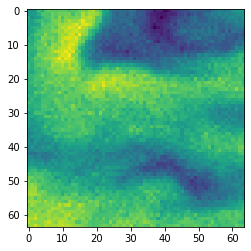

In [510]:
plt.imshow(np.transpose(test_img, (1, 2, 0)))

In [481]:
test_img = np.transpose(dataset_train[0], (1, 2, 0))

In [269]:
test_img_rotated = skimage.transform.rotate(test_img, np.float32(360*np.random.rand(1))).astype(np.float32)

In [249]:
import matplotlib.pyplot as plt

In [482]:
test_img.shape

(64, 64, 1)

In [488]:
test_img.squeeze(-1).shape

(64, 64)

In [ ]:
skimage.transform.rescale(test_img, 2, channel_axis=-1).shape

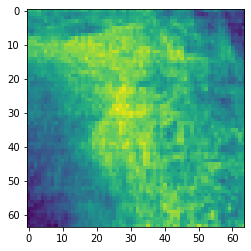

In [270]:
plt.imshow(test_img)

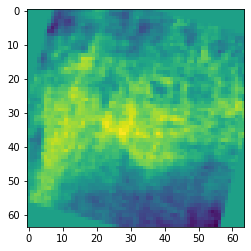

In [271]:
plt.imshow(test_img_rotated)

In [44]:
x =  np.ones((1, 3, 3))

In [46]:
xx = np.repeat(x, 3, axis=0)

In [47]:
xx.shape

(3, 3, 3)